In [1]:
import torch
import torchvision
import argparse
import yaml
import os
from torchvision.utils import make_grid
from PIL import Image
from tqdm import tqdm
from models.unet_cond_base import Unet
from models.vqvae import VQVAE
from scheduler.linear_noise_scheduler import LinearNoiseScheduler
from scheduler.linear_noise_scheduler_ddim import LinearNoiseSchedulerDDIM
from utils.config_utils import *
from collections import OrderedDict
from datetime import datetime
from tools.sample_ddpm_attr_cond import sample, ddim_inversion

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
""" module of functions related to discovering feature axis """

import time
import numpy as np
import sklearn.linear_model as linear_model


def find_feature_axis(z, y, method='linear', **kwargs_model):
    """
    function to find axis in the latent space that is predictive of feature vectors

    :param z: vectors in the latent space, shape=(num_samples, num_latent_vector_dimension)
    :param y: feature vectors, shape=(num_samples, num_features)
    :param method: one of ['linear', 'logistic'], or a sklearn.linear_model object, (eg. sklearn.linear_model.ElasticNet)
    :param kwargs_model: parameters specific to a sklearn.linear_model object, (eg., penalty=’l2’)
    :return: feature vectors, shape = (num_latent_vector_dimension, num_features)
    """

    if method == 'linear':
        model = linear_model.LinearRegression(**kwargs_model)
        model.fit(z, y)
    elif method == 'tanh':
        def arctanh_clip(y):
            return np.arctanh(np.clip(y, np.tanh(-3), np.tanh(3)))

        model = linear_model.LinearRegression(**kwargs_model)

        model.fit(z, arctanh_clip(y))
    else:
        raise Exception('method has to be one of ["linear", "tanh"]')

    return model.coef_.transpose()


def normalize_feature_axis(feature_slope):
    """
    function to normalize the slope of features axis so that they have the same length

    :param feature_slope: array of feature axis, shape = (num_latent_vector_dimension, num_features)
    :return: same shape of input
    """

    feature_direction = feature_slope / np.linalg.norm(feature_slope, ord=2, axis=0, keepdims=True)
    return feature_direction


def disentangle_feature_axis(feature_axis_target, feature_axis_base, yn_base_orthogonalized=False):
    """
    make feature_axis_target orthogonal to feature_axis_base

    :param feature_axis_target: features axes to decorrerelate, shape = (num_dim, num_feature_0)
    :param feature_axis_base: features axes to decorrerelate, shape = (num_dim, num_feature_1))
    :param yn_base_orthogonalized: True/False whether the feature_axis_base is already othogonalized
    :return: feature_axis_decorrelated, shape = shape = (num_dim, num_feature_0)
    """

    # make sure this funciton works to 1D vector
    if len(feature_axis_target.shape) == 0:
        yn_single_vector_in = True
        feature_axis_target = feature_axis_target[:, None]
    else:
        yn_single_vector_in = False

    # if already othogonalized, skip this step
    if yn_base_orthogonalized:
        feature_axis_base_orthononal = orthogonalize_vectors(feature_axis_base)
    else:
        feature_axis_base_orthononal = feature_axis_base

    # orthogonalize every vector
    feature_axis_decorrelated = feature_axis_target + 0
    num_dim, num_feature_0 = feature_axis_target.shape
    num_dim, num_feature_1 = feature_axis_base_orthononal.shape
    for i in range(num_feature_0):
        for j in range(num_feature_1):
            feature_axis_decorrelated[:, i] = orthogonalize_one_vector(feature_axis_decorrelated[:, i],
                                                                       feature_axis_base_orthononal[:, j])

    # make sure this funciton works to 1D vector
    if yn_single_vector_in:
        result = feature_axis_decorrelated[:, 0]
    else:
        result = feature_axis_decorrelated

    return result


def disentangle_feature_axis_by_idx(feature_axis, idx_base=None, idx_target=None, yn_normalize=True):
    """
    disentangle correlated feature axis, make the features with index idx_target orthogonal to
    those with index idx_target, wrapper of function disentangle_feature_axis()

    :param feature_axis:       all features axis, shape = (num_dim, num_feature)
    :param idx_base:           index of base features (1D numpy array), to which the other features will be orthogonal
    :param idx_target: index of features to disentangle (1D numpy array), which will be disentangled from
                                    base features, default to all remaining features
    :param yn_normalize:       True/False to normalize the results
    :return:                   disentangled features, shape = feature_axis
    """

    (num_dim, num_feature) = feature_axis.shape

    # process default input
    if idx_base is None or len(idx_base) == 0:    # if None or empty, do nothing
        feature_axis_disentangled = feature_axis
    else:                                         # otherwise, disentangle features
        if idx_target is None:                # if None, use all remaining features
            idx_target = np.setdiff1d(np.arange(num_feature), idx_base)

        feature_axis_target = feature_axis[:, idx_target] + 0
        feature_axis_base = feature_axis[:, idx_base] + 0
        feature_axis_base_orthogonalized = orthogonalize_vectors(feature_axis_base)
        feature_axis_target_orthogonalized = disentangle_feature_axis(
            feature_axis_target, feature_axis_base_orthogonalized, yn_base_orthogonalized=True)

        feature_axis_disentangled = feature_axis + 0  # holder of results
        feature_axis_disentangled[:, idx_target] = feature_axis_target_orthogonalized
        feature_axis_disentangled[:, idx_base] = feature_axis_base_orthogonalized

    # normalize output
    if yn_normalize:
        feature_axis_out = normalize_feature_axis(feature_axis_disentangled)
    else:
        feature_axis_out = feature_axis_disentangled
    return feature_axis_out


def orthogonalize_one_vector(vector, vector_base):
    """
    tool function, adjust vector so that it is orthogonal to vector_base (i.e., vector - its_projection_on_vector_base )

    :param vector0: 1D array
    :param vector1: 1D array
    :return: adjusted vector1
    """
    return vector - np.dot(vector, vector_base) / np.dot(vector_base, vector_base) * vector_base


def orthogonalize_vectors(vectors):
    """
    tool function, adjust vectors so that they are orthogonal to each other, takes O(num_vector^2) time

    :param vectors: vectors, shape = (num_dimension, num_vector)
    :return: orthorgonal vectors, shape = (num_dimension, num_vector)
    """
    vectors_orthogonal = vectors + 0
    num_dimension, num_vector = vectors.shape
    for i in range(num_vector):
        for j in range(i):
            vectors_orthogonal[:, i] = orthogonalize_one_vector(vectors_orthogonal[:, i], vectors_orthogonal[:, j])
    return vectors_orthogonal


def plot_feature_correlation(feature_direction, feature_name=None):
    import matplotlib.pyplot as plt

    len_z, len_y = feature_direction.shape
    if feature_name is None:
        feature_name = range(len_y)

    feature_correlation = np.corrcoef(feature_direction.transpose())

    c_lim_abs = np.max(np.abs(feature_correlation))

    plt.pcolormesh(np.arange(len_y+1), np.arange(len_y+1), feature_correlation,
                   cmap='coolwarm', vmin=-c_lim_abs, vmax=+c_lim_abs)
    plt.gca().invert_yaxis()
    plt.colorbar()
    # plt.axis('square')
    plt.xticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small', rotation='vertical')
    plt.yticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small')
    plt.show()


def plot_feature_cos_sim(feature_direction, feature_name=None):
    """
    plot cosine similarity measure of vectors

    :param feature_direction: vectors, shape = (num_dimension, num_vector)
    :param feature_name:      list of names of features
    :return:                  cosines similarity matrix, shape = (num_vector, num_vector)
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics.pairwise import cosine_similarity

    len_z, len_y = feature_direction.shape
    if feature_name is None:
        feature_name = range(len_y)

    feature_cos_sim = cosine_similarity(feature_direction.transpose())

    c_lim_abs = np.max(np.abs(feature_cos_sim))

    plt.pcolormesh(np.arange(len_y+1), np.arange(len_y+1), feature_cos_sim,
                   vmin=-c_lim_abs, vmax=+c_lim_abs, cmap='coolwarm')
    plt.gca().invert_yaxis()
    plt.colorbar()
    # plt.axis('square')
    plt.xticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small', rotation='vertical')
    plt.yticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small')
    plt.show()
    return feature_cos_sim





In [10]:
# Read the config file #
#with open('celebhq-1024-64-16k-komondor_b/celeba_komondor_16k_b.yaml', 'r') as file:
#with open('celebhq-1024-64-16k-komondor/celeba_komondor_16k.yaml', 'r') as file:
#with open('celebhq-512-64/celeba_komondor_512.yaml', 'r') as file:
with open('celebhq-512-64-train-komondor_b/celeba_komondor_512_b.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
print(config)
########################

diffusion_config = config['diffusion_params']
dataset_config = config['dataset_params']
diffusion_model_config = config['ldm_params']
autoencoder_model_config = config['autoencoder_params']
train_config = config['train_params']
sample_config = config['sample_params']

########## Create the noise scheduler #############

if sample_config['use_ddim']:
    print('Using DDIM')
    scheduler = LinearNoiseSchedulerDDIM(num_timesteps=diffusion_config['num_timesteps'],
                                            beta_start=diffusion_config['beta_start'],
                                            beta_end=diffusion_config['beta_end'])
else:
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                    beta_start=diffusion_config['beta_start'],
                                    beta_end=diffusion_config['beta_end'])
###############################################

########## Load Unet #############
model = Unet(im_channels=autoencoder_model_config['z_channels'],
                model_config=diffusion_model_config).to(device)
model.eval()
if os.path.exists(os.path.join(train_config['task_name'],
                                train_config['ldm_ckpt_name'])):
    

    ddp_state_dict = torch.load(os.path.join(train_config['task_name'],
                                                    train_config['ldm_ckpt_name']),
                                        map_location=device)
    new_state_dict = OrderedDict()
    for k, v in ddp_state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove `module.`
        new_state_dict[name] = v
    
    ddp_state_dict = new_state_dict
    print('Loaded unet checkpoint')
    model.load_state_dict(ddp_state_dict)
else:
    raise Exception('Model checkpoint {} not found'.format(os.path.join(train_config['task_name'],
                                                                        train_config['ldm_ckpt_name'])))
#####################################

# Create output directories
if not os.path.exists(train_config['task_name']):
    os.mkdir(train_config['task_name'])

########## Load VQVAE #############
vae = VQVAE(im_channels=dataset_config['im_channels'],
            model_config=autoencoder_model_config).to(device)
vae.eval()

# Load vae if found
if os.path.exists(os.path.join(train_config['task_name'],
                                train_config['vqvae_autoencoder_ckpt_name'])):
    print('Loaded vae checkpoint')

    vae_state_dict = torch.load(os.path.join(train_config['task_name'],
                                                train_config['vqvae_autoencoder_ckpt_name']),
                                    map_location=device)
    
    
    new_state_dict = OrderedDict()

    for k, v in vae_state_dict.items():
        if k.startswith('module.'):
            name = k[7:]
        new_state_dict[name] = v   

    #new_state_dict = vae_state_dict     
    
    vae.load_state_dict(new_state_dict, strict=True)
else:
    raise Exception('VAE checkpoint {} not found'.format(os.path.join(train_config['task_name'],
                                                train_config['vqvae_autoencoder_ckpt_name'])))
#####################################



{'task_name': 'celebhq-512-64-train-komondor_b', 'continue': True, 'last_step': 0, 'last_epoch': 199, 'dataset_params': {'im_path': 'data/CelebAMask-HQ', 'im_channels': 3, 'im_size': 512, 'name': 'celebhq'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0015, 'beta_end': 0.0195}, 'ldm_params': {'down_channels': [512, 768, 768, 1024], 'mid_channels': [1024, 768], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['attribute'], 'attribute_condition_config': {'attribute_condition_num': 19, 'attribute_condition_selected_attrs': ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']}}}, 'a

In [2]:
raw_dir = '/mnt/g/data/latents/700/raw/big_nose'

# load all files in the directory
files = os.listdir(raw_dir)
files = [f for f in files if f.endswith('.pt')]

# load all latents
latents = torch.tensor([])
attributes = torch.tensor([])
for f in tqdm(files):
    dict = torch.load(os.path.join(raw_dir, f))
    l = dict['latents']
    a = dict['attribute_desc']
    del dict
    l = l[-1, :, :, :, :]

    latents = torch.cat((latents, l), dim=0)
    attributes = torch.cat((attributes, a), dim=0)

# save the latents and attributes
torch.save({'latents': latents, 'attributes': attributes}, os.path.join(raw_dir, 'start_latents_attributes.pt'))



  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [07:31<00:00, 11.30s/it]


In [3]:
# load from torch checkpoint
#dict = torch.load('latents_glasses_2.pt')
dict = torch.load('/mnt/g/data/latents/700/raw/smiling/start_latents_attributes.pt')
latents = dict['latents']
attribute_desc = dict['attributes']

In [4]:
latents.shape

torch.Size([2000, 3, 64, 64])

In [5]:
attribute_desc.shape

torch.Size([2000, 20])

In [6]:
attribute_desc[:, -1]

tensor([0., 0., 0.,  ..., 1., 1., 1.])

In [7]:
def flatten_latents(latents):
    # get shape of latents
    shape = latents.shape
    
    flattened_latents = torch.zeros(shape[0], shape[1] * shape[2] * shape[3])

    for i in range(shape[0]):
        flattened_latents[i] = latents[i].flatten()

    return flattened_latents
        

In [8]:
def reverse_flatten_latents(flattened_latents, shape):
    # get shape of latents
    shape = shape

    latents = torch.zeros(shape[0], shape[1], shape[2], shape[3])

    for i in range(shape[0]):
        latents[i] = flattened_latents[i].reshape(shape[1], shape[2], shape[3])

    return latents

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


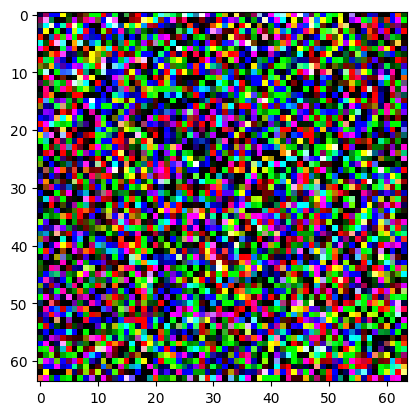

In [9]:
import matplotlib.pyplot as plt
plt.imshow(latents[1].permute(1,2,0).cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 12288])


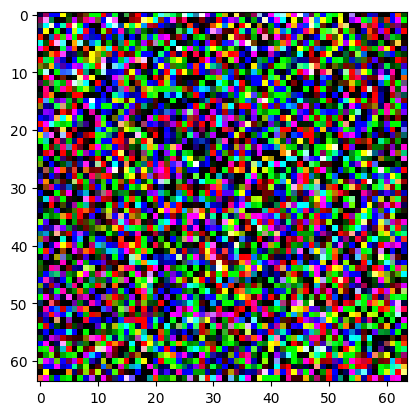

In [10]:
res_flat = flatten_latents(latents[1:2])
print(res_flat.shape)
# plot the results

plt.imshow(reverse_flatten_latents(res_flat, (1,3,64,64))[0].permute(1,2,0).cpu().numpy())
plt.show()



In [11]:
print(min(res_flat[0].cpu().numpy()))

-3.6519556


In [12]:
flattened_latents = flatten_latents(latents)

attribute_np = attribute_desc.cpu().numpy()


In [13]:
feature_slope = find_feature_axis(flattened_latents, attribute_np, method='tanh')

""" normalize the feature vectors """
yn_normalize_feature_direction = True
if yn_normalize_feature_direction:
    feature_direction = normalize_feature_axis(feature_slope)
else:
    feature_direction = feature_slope

In [14]:
len_z, len_y = feature_direction.shape

In [15]:
len_z, len_y

(12288, 20)

In [16]:
feature_direction_disentangled = disentangle_feature_axis_by_idx(
    feature_direction, idx_base=range(len_y - 1), idx_target=None, yn_normalize=True)

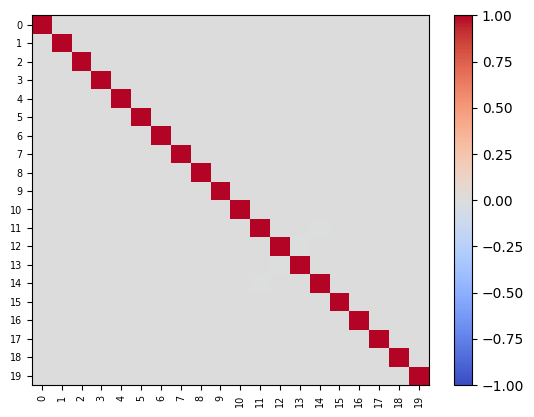

array([[ 1.00000048e+00, -6.51925802e-09,  5.47152013e-09,
        -1.21071935e-08, -1.22236088e-08, -5.58793545e-09,
         1.55996531e-08,  6.51925802e-09, -1.15251169e-08,
         1.30967237e-09,  2.93366611e-08,  5.82076609e-09,
         6.05359674e-09, -2.08383426e-08, -3.95812094e-08,
        -1.69966370e-08,  1.01281330e-08, -1.22818165e-08,
        -4.54019755e-09,  1.33877620e-08],
       [-6.51925802e-09,  1.00000000e+00,  3.05008143e-08,
        -2.32830644e-09,  7.21774995e-09,  3.10246833e-08,
        -4.88944352e-09,  1.35041773e-08, -1.72294676e-08,
        -1.67638063e-08,  3.72529030e-09,  1.07102096e-08,
        -2.09547579e-09, -6.28642738e-09,  1.35041773e-08,
        -2.79396772e-09,  4.65661287e-10, -9.08039510e-09,
         1.05064828e-08, -7.91624188e-09],
       [ 5.47152013e-09,  3.05008143e-08,  1.00000083e+00,
        -5.82076609e-10,  1.21071935e-08, -1.04191713e-08,
         3.37604433e-09,  1.00117177e-08, -7.16681825e-09,
        -1.11758709e-08, -1.4

In [17]:
plot_feature_cos_sim(feature_direction_disentangled)

In [18]:
print(feature_direction_disentangled.shape)

(12288, 20)


In [19]:
# swap the axes
feature_direction_disentangled = feature_direction_disentangled.T

In [20]:
print(feature_direction_disentangled.shape)

(20, 12288)


In [21]:
(20, latents.shape[1:])

(20, torch.Size([3, 64, 64]))

In [22]:
# reshape the feature_direction_disentangled
feature_direction_disentangled = reverse_flatten_latents(torch.tensor(feature_direction_disentangled).to(device), (20, 3, 64, 64))

In [25]:
# plot the feature direction
import matplotlib.pyplot as plt

feature_direction_disentangled = torch.tensor(feature_direction_disentangled)[19]



/tmp/ipykernel_612/3585322925.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_direction_disentangled = torch.tensor(feature_direction_disentangled)[19]


IndexError: index 19 is out of bounds for dimension 0 with size 3

In [34]:
print(feature_direction_disentangled.min(), feature_direction_disentangled.max())

tensor(-0.0407) tensor(0.0386)


In [45]:
tmp = feature_direction_disentangled.permute(1,2,0)

# clip the values
tmp = torch.clamp(tmp, 0.005, tmp.max())

tmp = (tmp - 0) / (tmp.max() - 0)

print(tmp.min(), tmp.max())


tensor(0.1296) tensor(1.)


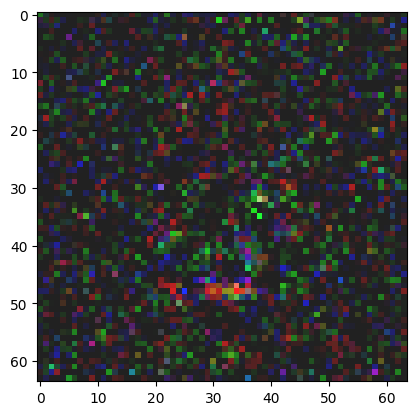

In [46]:
plt.imshow(tmp)
plt.show()

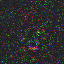

In [50]:
# show with pil
img = torchvision.transforms.ToPILImage()(tmp.permute(2,0,1))
img.show()

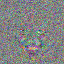

In [51]:
tmp = feature_direction_disentangled.permute(1,2,0)

tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())

img = torchvision.transforms.ToPILImage()(tmp.permute(2,0,1))
img.show()

In [27]:
print(min(feature_direction_disentangled.flatten()), max(feature_direction_disentangled.flatten()))

tensor(-0.0407) tensor(0.0386)


In [29]:
im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])

torch.manual_seed(10)

noise_input = torch.randn((train_config['num_samples'],
                        autoencoder_model_config['z_channels'],
                        im_size,
                        im_size)).to(device)

noise_input += feature_direction_disentangled.to(device) * 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])


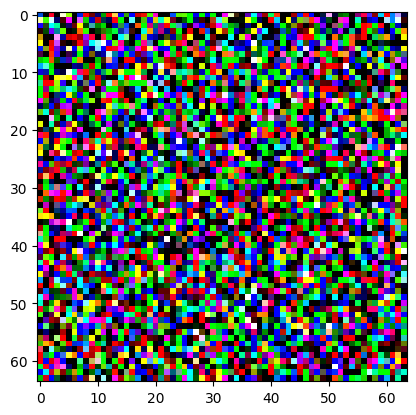

In [115]:
# load image x0_999.png
image = torch.load('celebhq-1024-64-16k-komondor/cond_attr_samples/20241006-173428/20241006-173429/xt_900.pt')
print(image.shape)



# plot the image
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.show()


In [88]:
print(min(image.flatten()), max(image.flatten()))

tensor(-3.6473, device='cuda:0') tensor(4.1163, device='cuda:0')


In [116]:
image_glasses = image + feature_direction_disentangled.to(device) * 10
noise_input = image_glasses

In [90]:
print(min(image_glasses.flatten()), max(image_glasses.flatten()))

tensor(-3.6452, device='cuda:0') tensor(4.0807, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


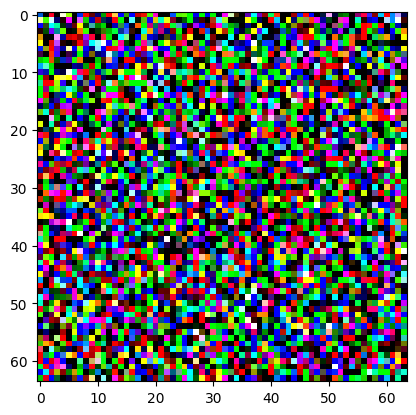

In [91]:
# plot the image
plt.imshow(image_glasses[0].permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
image_glasses

In [69]:
print(noise_input.shape)

torch.Size([1, 3, 64, 64])


In [30]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

In [31]:
#  ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']
cond = torch.tensor([[1, # Male
                      0, # Young
                      0, # Bald
                      1, # Bangs
                      0, # Receding_Hairline
                      0, # Black_Hair
                      1, # Blond_Hair
                      0, # Brown_Hair
                      0, # Gray_Hair
                      0, # Straight_Hair
                      1, # Wavy_Hair
                      1, # No_Beard
                      0, # Goatee
                      0, # Mustache
                      0, # Sideburns
                      0, # Narrow_Eyes
                      0, # Oval_Face
                      0, # Pale_Skin
                      0  # Pointy_Nose
                      ]]).to(device)

In [32]:
with torch.no_grad():
    for i in range(1):
        ims, cond_trans = sample(model, cond, scheduler, train_config, diffusion_model_config,
                    autoencoder_model_config, diffusion_config, dataset_config, vae, use_ddim=True, dir=current_time, noise_input=noise_input, num_steps=1000, start_step=0)

    

100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


In [128]:
cond_trans = {}
cond_trans['attribute']  = cond

In [149]:
# ddim inversion
with torch.no_grad():
    intermediate_latents = ddim_inversion(scheduler, vae, ims, diffusion_config, cond_trans, model, train_config, 1000, dir=current_time)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [02:05<00:00,  7.95it/s]


In [181]:
import copy
# copy the intermediate latents
intermediate_latents_copy = copy.deepcopy(intermediate_latents)

In [179]:
start_latent = copy.deepcopy(intermediate_latents_copy[-1])
start_latent += feature_direction_disentangled.to(device) * 10

In [167]:
noise_input = noise_input + feature_direction_disentangled.to(device) * 20

In [168]:
#  ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']
cond = torch.tensor([[0, # Male
                      0, # Young
                      0, # Bald
                      1, # Bangs
                      0, # Receding_Hairline
                      0, # Black_Hair
                      0, # Blond_Hair
                      0, # Brown_Hair
                      1, # Gray_Hair
                      0, # Straight_Hair
                      1, # Wavy_Hair
                      1, # No_Beard
                      0, # Goatee
                      0, # Mustache
                      0, # Sideburns
                      0, # Narrow_Eyes
                      0, # Oval_Face
                      0, # Pale_Skin
                      0  # Pointy_Nose
                      ]]).to(device)

In [177]:
with torch.no_grad():
    for i in range(1):
        ims, _ = sample(model, cond, scheduler, train_config, diffusion_model_config,
                    autoencoder_model_config, diffusion_config, dataset_config, vae, use_ddim=True, dir=current_time, noise_input=start_latent, num_steps=1000, start_step=0)

100%|██████████| 1000/1000 [02:14<00:00,  7.41it/s]


In [194]:
from dataset.celeb_dataset import CelebDataset

diffusion_model_config = config['ldm_params']
print(diffusion_model_config)

temp_conf = diffusion_model_config.copy()

# add Eyeglasses to the condition
temp_conf['condition_config']['attribute_condition_config']['attribute_condition_selected_attrs'].append('Eyeglasses')
temp_conf['condition_config']['attribute_condition_config']['attribute_condition_num'] = len(temp_conf['condition_config']['attribute_condition_config']['attribute_condition_selected_attrs'])

{'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['attribute'], 'attribute_condition_config': {'attribute_condition_num': 19, 'attribute_condition_selected_attrs': ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']}}}


In [197]:
im_dataset_train = CelebDataset(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'],
                                use_latents=False,
                                latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name']),
                                condition_config=temp_conf['condition_config'],
                                )

100%|██████████| 30000/30000 [00:00<00:00, 39968.48it/s]

Found 30000 images
Found 0 masks
Found 0 captions
Found 30000 attributes


In [198]:
# go through the dataset find all image with 1 at position 19 in the condition
indexes_with_eyeglasses = []
indexes_without_eyeglasses = []
for i in tqdm(range(len(im_dataset_train))):
    _, cond = im_dataset_train[i]
    if cond['attribute'][19] == 1:
        indexes_with_eyeglasses.append(i)
    else:
        indexes_without_eyeglasses.append(i)


print(len(indexes_with_eyeglasses))

100%|██████████| 27000/27000 [07:20<00:00, 61.29it/s]

1369


In [199]:
# save the indexes
import pickle

with open('indexes_with_eyeglasses_all_train.pkl', 'wb') as f:
    pickle.dump(indexes_with_eyeglasses, f)

with open('indexes_without_eyeglasses_all_train.pkl', 'wb') as f:
    pickle.dump(indexes_without_eyeglasses, f)

In [201]:
im_dataset_val = CelebDataset(split='val',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'],
                                use_latents=False,
                                latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name']),
                                condition_config=temp_conf['condition_config'],
                                )

100%|██████████| 30000/30000 [00:00<00:00, 78741.97it/s]

Found 30000 images
Found 0 masks
Found 0 captions
Found 30000 attributes


In [202]:
# go through the dataset find all image with 1 at position 19 in the condition
indexes_with_eyeglasses = []
indexes_without_eyeglasses = []
for i in tqdm(range(len(im_dataset_val))):
    _, cond = im_dataset_val[i]
    if cond['attribute'][19] == 1:
        indexes_with_eyeglasses.append(i)
    else:
        indexes_without_eyeglasses.append(i)


print(len(indexes_with_eyeglasses))

100%|██████████| 600/600 [00:09<00:00, 62.12it/s]

18


In [203]:
# save the indexes
import pickle

with open('indexes_with_eyeglasses_all_val.pkl', 'wb') as f:
    pickle.dump(indexes_with_eyeglasses, f)

with open('indexes_without_eyeglasses_all_val.pkl', 'wb') as f:
    pickle.dump(indexes_without_eyeglasses, f)